<a href="https://colab.research.google.com/github/O-Kpy/Project/blob/main/%E1%84%80%E1%85%B5%E1%84%89%E1%85%A1%E1%86%BC%E1%84%83%E1%85%A6%E1%84%8B%E1%85%B5%E1%84%90%E1%85%A5(%E1%84%91%E1%85%A9%E1%86%A8%E1%84%8B%E1%85%A7%E1%86%B7)_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D(project2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats
import os

In [2]:
!apt-get update -qq  ## 나눔 설치
!apt-get install fonts-nanum* -qq

In [3]:
import matplotlib as mpl
import matplotlib.font_manager as fm   ## 폰트 매니저
fontpath = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf' 
font = fm.FontProperties(fname=fontpath, size=9).get_name()
plt.rc('font', family=font) 
mpl.font_manager._rebuild()

# Read Me

---

- 개 더운 여름(2021-07-27)에 폭염 때문에 빡친 나는 언제까지 폭염이 닥칠 것인가에 대한 데이터 분석을 시작한다.

- 데이터 셋은 기상청기상자료개방포털(https://data.kma.go.kr/cmmn/main.do)에서 가져 왔다.

- 데이터는 [일시, 지점, 폭염여부(O/X), 최고체감온도(°C), 최고기온(°C), 평균기온(°C), 최저기온(°C), 평균상대습도(%), 폭염특보(O/X), 폭염영향예보(단계), 열대야(O/X), 자외선지수(단계)]의 테이블로 구성되어 있다.

- 데이터의 기간[일시]는 **2019-05 ~ 2021-07**까지 수집 되었다.

- 53946 rows 구성의 데이터이다.

- 각 컬럼에 NaN값도 존재한다. ==> 그 지역, 그 시기 값의 평균or중위수로 치환

- 데이터[폭염영향예보(단계)] = ' ', '관심', '주의', '경고', '심각'으로 구성
 - ' '는 폭염과 관련 없는 날씨를 의미 하기 때문에 '평시'로 replace

In [33]:
data = pd.read_excel('/content/drive/MyDrive/dataset/공공데이터/폭염데이터-기상청/기상데이터(폭염).xlsx')
data = data.sort_values('일시')

In [34]:
data['일시'] = pd.to_datetime(data['일시'], format='%Y-%m-%d')

data['year'] = data['일시'].dt.year
data['month'] = data['일시'].dt.month
data['day'] = data['일시'].dt.day

In [6]:
data

,일시,지점,폭염여부(O/X),최고체감온도(°C),최고기온(°C),평균기온(°C),최저기온(°C),평균상대습도(%),폭염특보(O/X),폭염영향예보(단계),열대야(O/X),자외선지수(단계),year,month,day
5181,2019-05-01,철원(95),X,21.9,23.6,15.9,8.8,59.8,X,,X,낮음,2019,5,1
5124,2019-05-01,화성(571),X,19.8,19.4,13.3,8.5,65.0,X,,X,낮음,2019,5,1
5125,2019-05-01,성남(572),X,22.0,22.8,15.4,8.9,62.0,X,,X,높음,2019,5,1
5126,2019-05-01,과천(590),X,22.0,22.8,14.9,7.8,55.0,X,,X,낮음,2019,5,1
5127,2019-05-01,양주(598),X,22.5,23.3,15.7,8.1,57.0,X,,X,낮음,2019,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53839,2021-07-26,장흥(260),X,31.9,NaN,NaN,NaN,74.8,O,경고,X,매우높음,2021,7,26
53840,2021-07-26,해남(261),X,32.4,NaN,NaN,NaN,73.4,O,경고,X,매우높음,2021,7,26
53841,2021-07-26,고흥(262),X,31.3,NaN,NaN,NaN,73.9,O,경고,X,매우높음,2021,7,26
53823,2021-07-26,보은(226),O,33.0,NaN,NaN,NaN,76.8,O,경고,X,매우높음,2021,7,26


Text(0, 0.5, '')

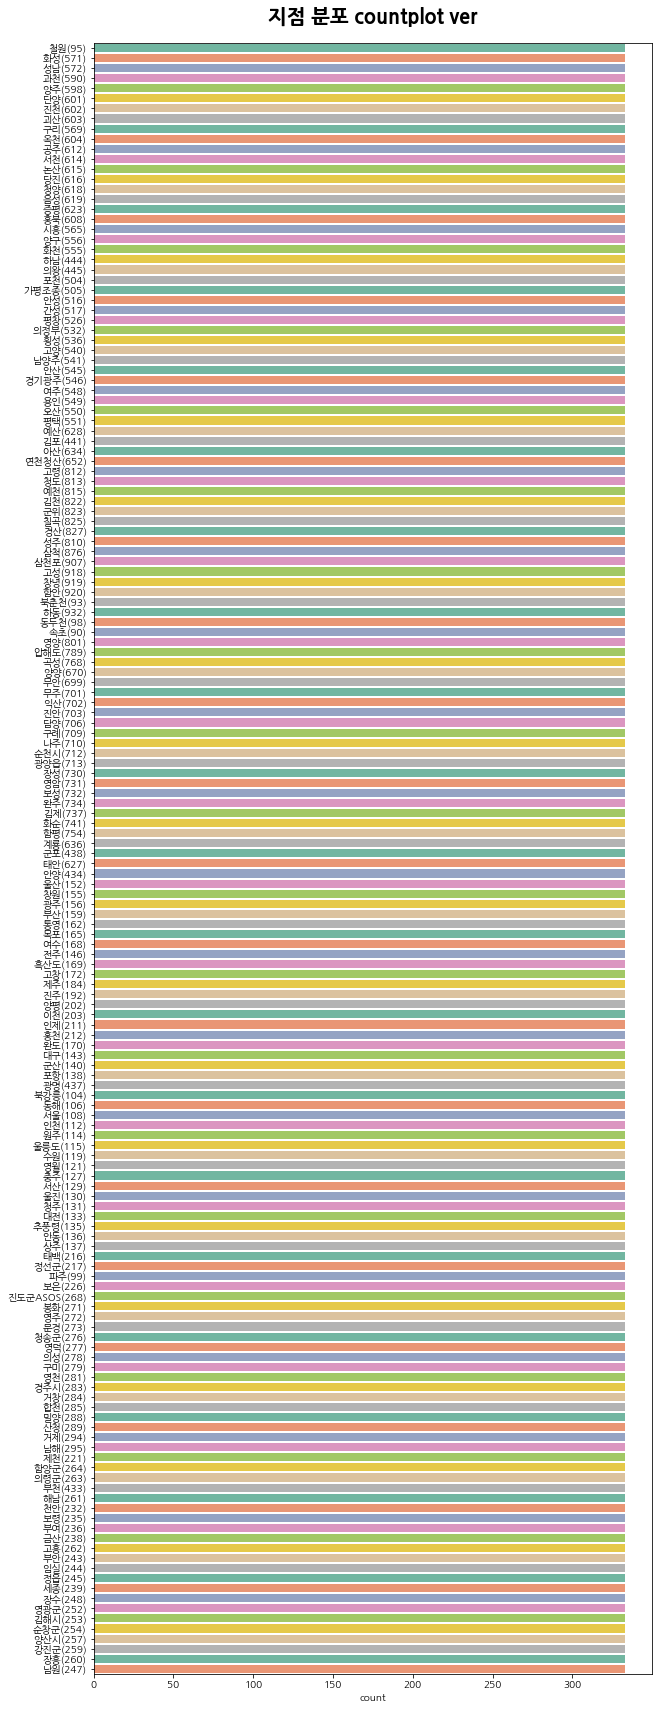

In [35]:
plt.figure(figsize=(10,30))
sns.countplot(y=data['지점'], palette=sns.color_palette('Set2', n_colors=data['지점'].nunique()))
plt.title('지점 분포 countplot ver', fontsize=20, pad=20, fontweight='bold')
plt.ylabel('')

In [138]:
# 지역명 전처리(깔끔)
data['지점'] = data['지점'].apply(lambda x: x.split('(')[0])

누락된 날짜, 지점은 없는 것으로 해석

---

# 누락 값 처리(Feature Engineering)

In [139]:
# 각 컬럼의 NaN 나타내는 테이블(table)-야매ver
data_isnull = data.isnull().sum().reset_index(name='count')
data_nullmean = data.isnull().mean().reset_index(name='percent')

data_isnull_table = data_isnull.merge(data_nullmean, how='left', on='index').set_index('index').sort_values('percent', ascending=False)
data_isnull_table

,count,percent
index,,
평균상대습도(%),2286,0.042376
최고체감온도(°C),2102,0.038965
최저기온(°C),493,0.009139
최고기온(°C),490,0.009083
평균기온(°C),458,0.008490
일시,0,0.000000
지점,0,0.000000
폭염여부(O/X),0,0.000000
폭염특보(O/X),0,0.000000


In [140]:
# NaN값들을 지점 별로 value_counts(), unstack()한 table ==> 시각화 하기 위해서
# 각 값들은 NaN값의 개수를 나타낸 것

humid = data.groupby('지점')['평균상대습도(%)'].value_counts(dropna=False).unstack().fillna(0).iloc[:,0].reset_index(name='평균상대습도(%)')
sensory = data.groupby('지점')['최고체감온도(°C)'].value_counts(dropna=False).unstack().fillna(0).iloc[:,0].reset_index(name='최고체감온도(°C)')
low = data.groupby('지점')['최저기온(°C)'].value_counts(dropna=False).unstack().fillna(0).iloc[:,0].reset_index(name='최저기온(°C)')
high = data.groupby('지점')['최고기온(°C)'].value_counts(dropna=False).unstack().fillna(0).iloc[:,0].reset_index(name='최고기온(°C)')
mean = data.groupby('지점')['평균기온(°C)'].value_counts(dropna=False).unstack().fillna(0).iloc[:,0].reset_index(name='평균기온(°C)')

null_table = humid.merge(sensory, how='left', on='지점').merge(low, how='left', on='지점').merge(high, how='left', on='지점').merge(mean, how='left', on='지점').set_index('지점')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

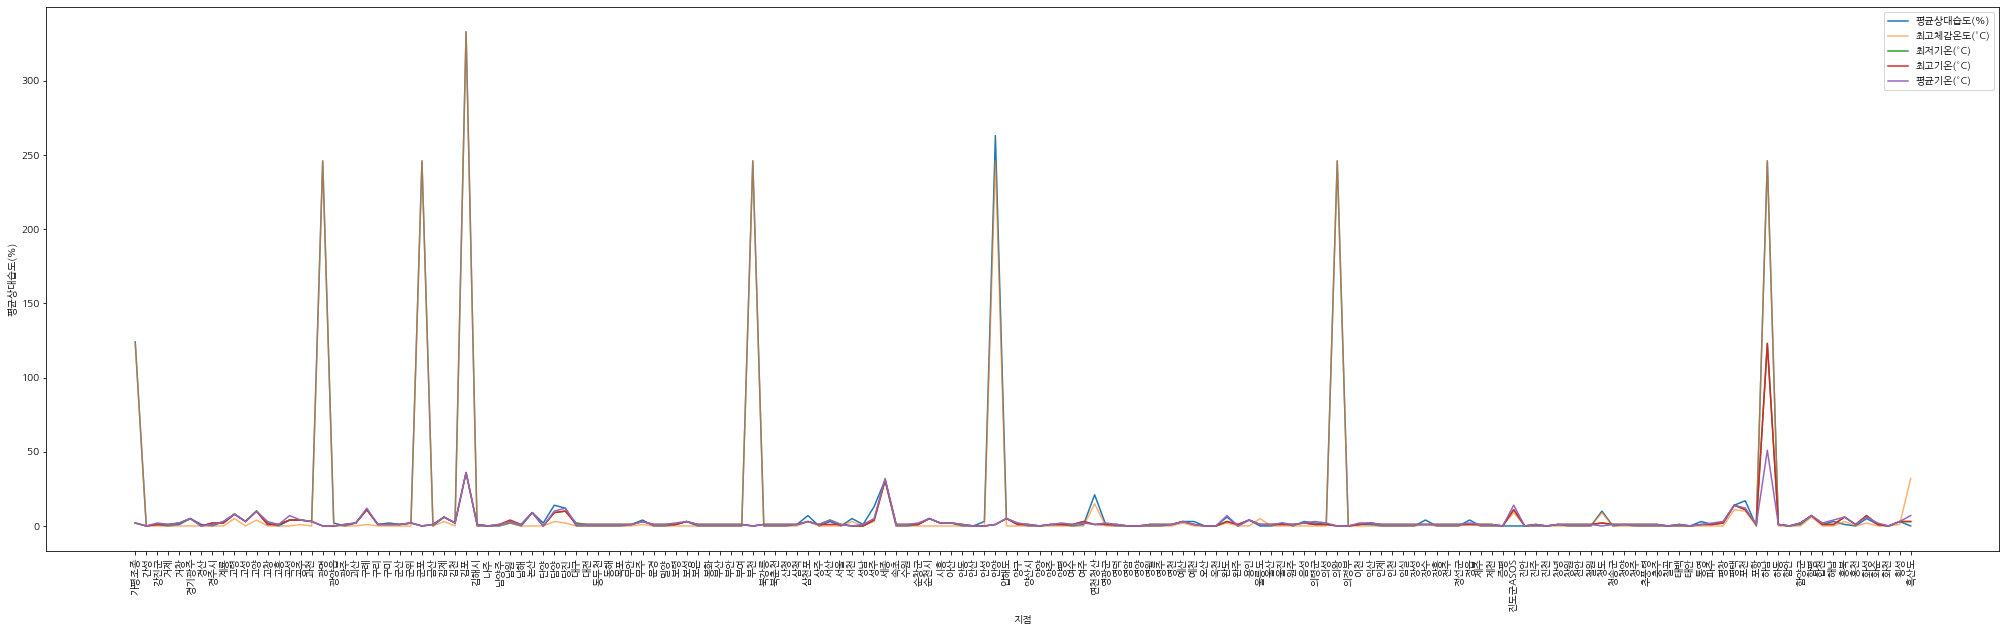

In [141]:
plt.figure(figsize=(35,10))
sns.lineplot(null_table.index, null_table['평균상대습도(%)'], label='평균상대습도(%)')
sns.lineplot(null_table.index, null_table['최고체감온도(°C)'], label='최고체감온도(°C)', alpha=0.6)
sns.lineplot(null_table.index, null_table['최저기온(°C)'], label='최저기온(°C)')
sns.lineplot(null_table.index, null_table['최고기온(°C)'], label='최고기온(°C)')
sns.lineplot(null_table.index, null_table['평균기온(°C)'], label='평균기온(°C)')
plt.xticks(rotation=90)

하남에서는 전체적으로 누락값이 많이 관측되고 [의왕, 안양, 부천, 김포, 군포, 광명, 가평조종]에서는 '최고체감온도', '평균상대습도'가 비슷하게 누락값이 많이 관찰된다.

==> 누락 값이 적은 곳은 mean, median때려도 상관 없지만, [의왕, 안양, 부천, 김포, 군포, 광명, 가평조종]은 주의 깊은 누락 값 채우기를 해야한다.

In [36]:
data['폭염영향예보(단계)'] = data['폭염영향예보(단계)'].replace(' ', '평시')
data['폭염영향예보(단계)'].value_counts()

평시    38913
관심     6223
주의     5717
경고     3082
심각       11
Name: 폭염영향예보(단계), dtype: int64